# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
# from utils import data_read_dict, data_read_concat, data_merge
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize


name = 'LSTM_univariate2_classification'

In [2]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')
# %% read in data and adapt
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'EURUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)
# df = df.loc[(df.iloc[:, :4] != 0).all(axis=1)]
df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
np.random.seed(42)
# df = df.iloc[np.random.choice(list(range(df.shape[0])), size=df.shape[0], replace=False), :]


In [4]:
# create a list of our conditions #!!! 
conditions = [
    (df[target] <= -0.00000001),
    (df[target] > -0.00000001) & (df[target] <= 0.00000001),
    (df[target] > 0.00000001)
]

# create a list of the values we want to assign for each condition #!!! 
values = ['sell', 'hold', 'buy']
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments #!!! 
df['strategy'] = np.select(conditions, values)
df.strategy = df.strategy.astype(np.int32)

# display updated DataFrame #!!! 
df.head()

,EURUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,0.000275,2
2020-11-01 19:30:00,-0.000069,0
2020-11-01 19:40:00,0.000034,2
2020-11-01 19:50:00,0.000026,2


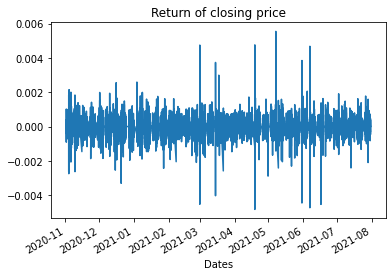

In [5]:
df['EURUSD BGNE Curncy Bid Close'].plot()
plt.title('Return of closing price')
plt.show()

In [6]:
lag = 128
h = 1
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, 1)

In [7]:
print(index_train.shape)
print(X_train.shape)
print(y_train.shape)

(23210,)
(23081, 128, 2)
(23081, 1)


In [8]:
a = np.array([sc.inverse_transform(X_train[i,:]) for i in range(X_train.shape[0])])
b = np.concatenate([sc.inverse_transform(X_train[:,i])[:,np.newaxis] for i in range(128)], axis=1)
a.shape == b.shape
np.abs(a - b).sum()

0.0

In [9]:
np.abs(a[:,-1] - df.loc[index_train].iloc[127:-2].values).sum()

9.621616654451048e-17

In [10]:
# assert ((df.values[:X_train.shape[0]] - sc.inverse_transform(X_train)[:,0])**2).sum() < 1e-10
# assert ((df.values[lag - 1:lag - 1 + X_train.shape[0]] - sc.inverse_transform(X_train)[:,-1])**2).sum() < 1e-10

# assert ((df.iloc[-X_test.shape[0] - lag - h:][:-lag - h].values - sc.inverse_transform(X_test)[:,0])**2).sum() < 1e-11
# assert index_test[0] == df.iloc[-X_test.shape[0] - lag - h:].index[0]
# for i in range(lag):
#     assert ((df.iloc[-X_test.shape[0] - lag - h:][i:-(lag + h -i)].values - sc.inverse_transform(X_test)[:,i])**2).sum() < 1e-10

# assert (sc_target.inverse_transform(X_train[:, 0, 1]) == df.iloc[:X_train.shape[0], 1].values).all()
# assert (sc_target.inverse_transform(X_train[:, -1, 1]) == df.iloc[lag - 1:lag - 1 + X_train.shape[0], 1].values).all()

# assert (sc_target.inverse_transform(X_val[:, 0, 1]) == df.iloc[X_train.shape[0] + lag + 1: lag + 1 + X_train.shape[0] + X_val.shape[0], 1].values).all()
# assert (sc_target.inverse_transform(X_val[:, -1, 1]) == df.iloc[X_train.shape[0] + lag + 1 + lag - 1: lag + 1 + lag - 1 + X_train.shape[0] + X_val.shape[0], 1].values).all()
# # # assert (sc_target.inverse_transform(X_val[:, -1, 1]) == df.iloc[127:127 + X_train.shape[0], 1].values).all()
# # print(sc.inverse_transform(X_test)[-10:, :4, 0])
# # print(index_test[-4:])
# # df.iloc[-10:, 0]
# a = (sc.inverse_transform(X_train)[:, 0] == df.iloc[:23081])
# np.sum((df.iloc[:23081].loc[np.invert(a).iloc[:, 0]] - sc.inverse_transform(X_train)[np.invert(a).iloc[:, 0], 0]) ** 2)


In [11]:
X_train = X_train#.astype(dtype)
X_val = X_val#.astype(dtype)
X_test = X_test#.astype(dtype)
y_train = sc_target.inverse_transform(y_train)
y_val = sc_target.inverse_transform(y_val)
y_test = sc_target.inverse_transform(y_test)

In [12]:
def LSTM_model():
    # The LSTM architecture
    act_fct = 'tanh'
    dr = 0.25
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=64, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(Flatten())
    my_LSTM_model.add(Dropout(dr))
    my_LSTM_model.add(Dense(units=128))
    my_LSTM_model.add(Dense(units=3, activation='softmax'))
    # my_LSTM_model.add(LSTM(units=1))
    return my_LSTM_model

In [13]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [14]:
def earlyStopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
if not os.path.exists('Benchmark/trained_models'):
    os.mkdir('Benchmark/trained_models')
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    'Benchmark/trained_models/%s____{epoch:04}.hdf5'%name,
    monitor='val_loss',
    save_best_only=False,
    verbose=1
)
def learning_rate_scheduler(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    elif epoch < 50:
        return 0.0001
    elif epoch < 100:
        return 0.00001
    else:
        return 0.000001

In [15]:
from tensorflow.keras.optimizers import Adam
my_LSTM_model = LSTM_model()
my_LSTM_model.compile(
    optimizer=Adam(
        learning_rate=0.05
    ),
    loss=SparseCategoricalCrossentropy(from_logits=False),
#     loss='accuracy',
    metrics=['kullback_leibler_divergence', 'accuracy'],
)

history = my_LSTM_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=True,
    callbacks=[
        # earlyStopping(),
        LearningRateScheduler(learning_rate_scheduler),
        model_checkpoints,
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

Epoch 1/100
722/722 [==============================] - 16s 17ms/step - loss: 1.3886 - kullback_leibler_divergence: 4.7820 - accuracy: 0.4798 - val_loss: 0.8387 - val_kullback_leibler_divergence: 2.3819 - val_accuracy: 0.4766

Epoch 00001: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0001.hdf5
Epoch 2/100
722/722 [==============================] - 12s 16ms/step - loss: 0.8144 - kullback_leibler_divergence: 2.9410 - accuracy: 0.4922 - val_loss: 0.8352 - val_kullback_leibler_divergence: 2.3836 - val_accuracy: 0.4892

Epoch 00002: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0002.hdf5
Epoch 3/100
722/722 [==============================] - 12s 16ms/step - loss: 0.8119 - kullback_leibler_divergence: 2.9746 - accuracy: 0.4884 - val_loss: 0.8727 - val_kullback_leibler_divergence: 2.3731 - val_accuracy: 0.4780

Epoch 00003: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0003.hdf5
Epoch 4/100
722/722 [====

In [16]:
with open(f'Benchmark/trained_models/{name}____history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [17]:
if 'my_LSTM_model' not in globals():
    model_last = sorted([i for i in os.listdir('Benchmark/trained_models/') if name in i and 'hdf5' in i])[-1]
    my_LSTM_model = tf.keras.models.load_model(
        os.path.join('Benchmark/trained_models', model_last),
        custom_objects={'kl_divergence': kullback_leibler_divergence}
    )
if 'history' not in globals():
    with open(f'Benchmark/trained_models/{name}____history.pkl', 'rb') as f:
        history = pickle.load(f)
if hasattr(history, 'history'):
    history = history.history

In [ ]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(history['kullback_leibler_divergence'], label='train')
plt.plot(history['val_kullback_leibler_divergence'], label='test')
plt.legend()
plt.show()

In [ ]:
my_LSTM_model.summary()

In [ ]:
opt_learn_rate_plot(
    my_LSTM_model,
    X_train[..., :1],
    y_train,
    10**-6,
    10**1,
    100,
    batch_size=64,
    steps_per_epoch=1,
    custom_objects={'kl_divergence': kullback_leibler_divergence}
)

## Econmetric measures

Definition of cumulated returns

In [ ]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

In [ ]:
X_train.shape

In [ ]:
#!!! for testing purposes
tmp_type = 'train'

X = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)
for i in range(lag):
    diff = np.abs(df.loc[eval(f"index_{tmp_type}")].iloc[i:-(lag - i + 1)].values - X[:,-(lag - i)]).sum(axis=0)
    assert diff[0] < 1e-6 and diff[1] < 0.5, 'df and X inversed are not the same'

X_ret_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 0]
y_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]

a = sc_target.inverse_transform(eval(f"y_{tmp_type}")).flatten()
b = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]
cc = df.loc[eval(f"index_{tmp_type}")].iloc[127:-2, 1].values
print(np.abs(cc[1:] - a[:-1]).sum(axis=0))
print(np.abs(cc - b).sum(axis=0))

In [ ]:
print((index_train[0:-129] == X_train_index[:, 0]).all())
print((index_train[127:-2] == X_train_index[:, -1]).all())

## read in data for econmic metric

In [ ]:
tmp_type = 'train'
X_ret_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 0] + 1
y_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1].round()

df_testing = df.loc[eval(f"index_{tmp_type}")].iloc[127:-2]
df_close_testing = df_close.loc[eval(f"index_{tmp_type}")].iloc[127:-2]
X_ret_testing.shape[0] == df_testing.shape[0]

In [ ]:
assert np.abs(cumulated_return(y_testing, X_ret_testing) - \
              cumulated_return(df_testing.values[:, 1], df_testing.values[:, 0] + 1)).sum() < 1e-10, "cumulated return of df and X are not the same"

In [ ]:
# Test eq
print((np.equal((y_testing.flatten() == 0), X_ret_testing -1 < - 0.00000001)).mean())
print((np.equal((y_testing.flatten() == 1), np.logical_and(X_ret_testing -1 >= -0.00000001, X_ret_testing -1 < 0.00000001 ))).mean())
print((np.equal((y_testing.flatten() == 2), X_ret_testing -1 >= 0.00000001)).mean())

print((np.equal((df_testing.values[:, 1] == 0), df_testing.values[:, 0] < -0.00000001)).mean())
print((np.equal((df_testing.values[:, 1] == 1), np.logical_and(df_testing.values[:, 0] >= -0.00000001, df_testing.values[:, 0] < 0.00000001 ))).mean())
print((np.equal((df_testing.values[:, 1] == 2), df_testing.values[:, 0] >= 0.00000001)).mean())

In [ ]:
# y_pred = predictions(
#     my_LSTM_model,
#     eval(f"X_{tmp_type}")[..., :1]
# )
# y_pred = np.argmax(y_pred, axis=1)
from copy import deepcopy
y_pred = deepcopy(y_testing)
np.random.shuffle(y_pred)

In [ ]:
for _ in range(10):
    np.random.shuffle(y_pred)
    plt.plot(cumulated_return(y_pred, X_ret_testing, 1000), color='grey', lw=0.5)
a = cumulated_return(y_testing, X_ret_testing, 1000)
plt.plot(a[1:], label='cumulated_return')
a = cumulated_return(y_train, X_ret_testing, 1000)
plt.plot(a[1:], label='y_train')
plt.semilogy()
plt.legend()
plt.show()

In [ ]:
df.columns

In [ ]:
if tmp_type == 'train':
    df_tmp = df.loc[X_train_index[:, -1]].loc[:, target].values + 1
    df_close_tmp = df_close.loc[X_train_index[:, -1]].iloc[:, target_column : target_column + 1].values
    print(df_close_tmp[-1] / df_close_tmp[0] * 1000)
    print(df_tmp.prod() * 1000)
    print(X_ret_testing.prod() * 1000)
    print(cumulated_return(y_testing * 0 + 2, X_ret_testing, 1000)[-1])

In [ ]:
print(X_ret_testing[1::3].prod()* 1000)
y_tmp = y_testing[1:] * 1
y_tmp[1::3] = 2
print(cumulated_return(y_tmp, X_ret_testing[1:], 1000)[-1])
y_tmp = y_train * 1
y_tmp[1::3] = 2
print(cumulated_return(y_tmp[:-1], X_ret_testing[1:], 1000)[-1])

In [ ]:
tmp_type = 'train'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")[..., :1]
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
x = np.concatenate(
    [
        cumulated_return(
            np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
            X_ret[1:],
            dtype=dtype
        )[:,np.newaxis] for i in range(50)
    ], axis=-1
)
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1), label='random', color='gray')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
plt.legend()
plt.semilogy()
plt.show()


In [ ]:
tmp_type = 'val'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")[..., :1]
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
x = np.concatenate(
    [
        cumulated_return(
            np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
            X_ret[1:],
            dtype=dtype
        )[:,np.newaxis] for i in range(50)
    ], axis=-1
)
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1), label='random', color='gray')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
plt.legend()
plt.semilogy()
plt.show()


In [ ]:
tmp_type = 'test'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")[..., :1]
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
x = np.concatenate(
    [
        cumulated_return(
            np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
            X_ret[1:],
            dtype=dtype
        )[:,np.newaxis] for i in range(50)
    ], axis=-1
)
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1), label='random', color='gray')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
plt.legend()
plt.semilogy()
plt.show()


cumulated_return(y_pred, X_ret, dtype=dtype)

In [ ]:
x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)

(x[-1] / x[0]) / (np.std(x[1:] / x[:-1]) * np.sqrt(6 * 24 * 250))

In [ ]:
# ax1 = fig.add_subplot(211)
# ax1.plot(index_train[X_train.shape[1]:], df_train[target], label='Training data')
# ax1.plot(index_val[X_train.shape[1]:], df_val[target], label='Validation data')
# ax1.plot(index_test[X_train.shape[1]:], df_test[target], label='Test data')
# ax1.set_xlabel('Dates')
# ax1.set_ylabel('Normalized Closing Returns')
# ax1.set_title("Close Price", fontsize=18)
# ax1.legend(loc="best", fontsize=12)